In [1]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# torch.cuda.is_available()
# torch.backends.cudnn.enabled

In [3]:
# set path
PATH = "data/cakepie/"
sz=224

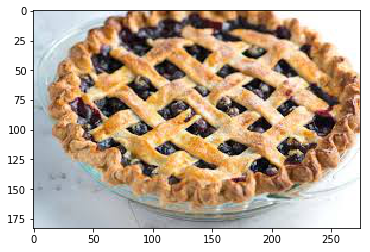

In [4]:
# show a pie
files = os.listdir(f'{PATH}valid/pie')[:5]
img = plt.imread(f'{PATH}valid/pie/{files[0]}')
plt.imshow(img);

In [5]:
# build the classfier
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


epoch      trn_loss   val_loss   accuracy       
    0      1.05282    0.710647   0.619048  
    1      0.871871   0.599394   0.714286        
    2      0.773525   0.510971   0.714286        
    3      0.705725   0.44144    0.809524        
    4      0.626351   0.389531   0.809524        
    5      0.553939   0.352189   0.809524        
    6      0.493911   0.313387   0.857143        
    7      0.440696   0.283702   0.904762        
    8      0.393203   0.257172   0.904762        
    9      0.356404   0.23626    0.904762        



[0.23625966906547546, 0.9047619104385376]

In [7]:
# truth for the validation set
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
# from here we know that 'icecream' is label 0 and 'pie' is label 1.
data.classes

['cake', 'pie']

In [9]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
print(log_preds.shape)
print(log_preds[:10])

(21, 2)
[[-0.04528 -3.11745]
 [-0.01249 -4.38873]
 [-0.02244 -3.80795]
 [-0.04381 -3.14981]
 [-0.00806 -4.82512]
 [-0.00194 -6.24808]
 [-0.00427 -5.45806]
 [-0.05019 -3.01692]
 [-0.00139 -6.57684]
 [-0.02665 -3.63831]]


In [10]:
log_preds[:10]

array([[-0.04528, -3.11745],
       [-0.01249, -4.38873],
       [-0.02244, -3.80795],
       [-0.04381, -3.14981],
       [-0.00806, -4.82512],
       [-0.00194, -6.24808],
       [-0.00427, -5.45806],
       [-0.05019, -3.01692],
       [-0.00139, -6.57684],
       [-0.02665, -3.63831]], dtype=float32)

In [11]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(pie)

In [12]:
def rand_by_mask(mask): 
    print (len(np.where(mask)[0]))
    return np.random.choice(np.where(mask)[0], min(len(np.where(mask)[0]), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [13]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [14]:

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

19
Correctly classified


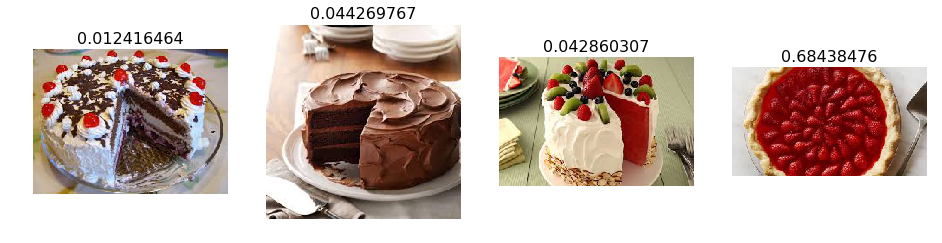

In [15]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

2
Incorrectly classified


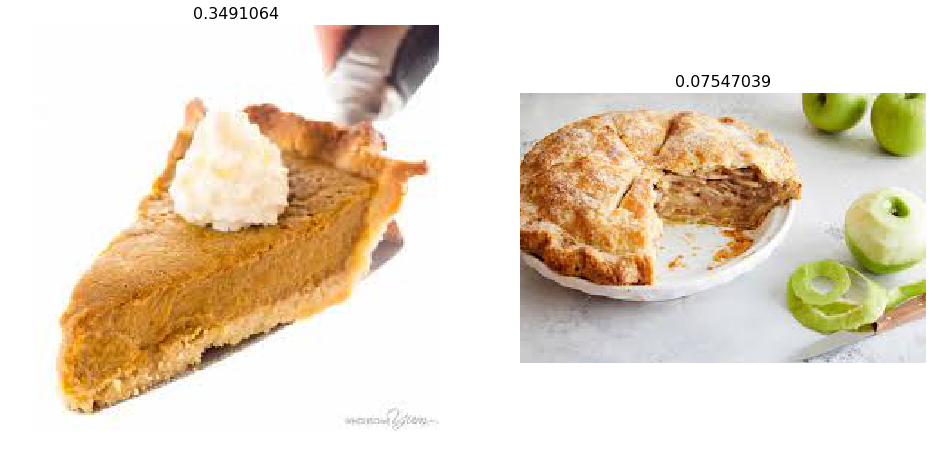

In [16]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [17]:

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct ice cream


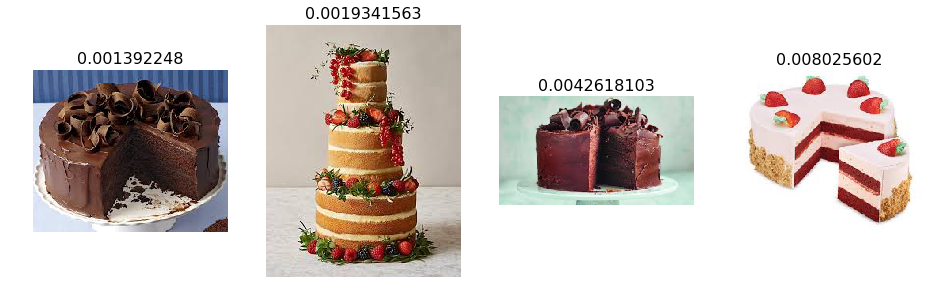

In [18]:
plot_val_with_title(most_by_correct(0, True), "Most correct ice cream")

Most correct pies


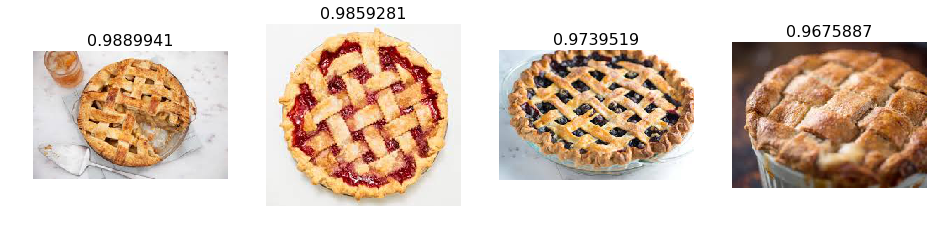

In [19]:
plot_val_with_title(most_by_correct(1, True), "Most correct pies")

In [20]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect ice cream")

Most incorrect ice cream
Not Found.


Most incorrect pies


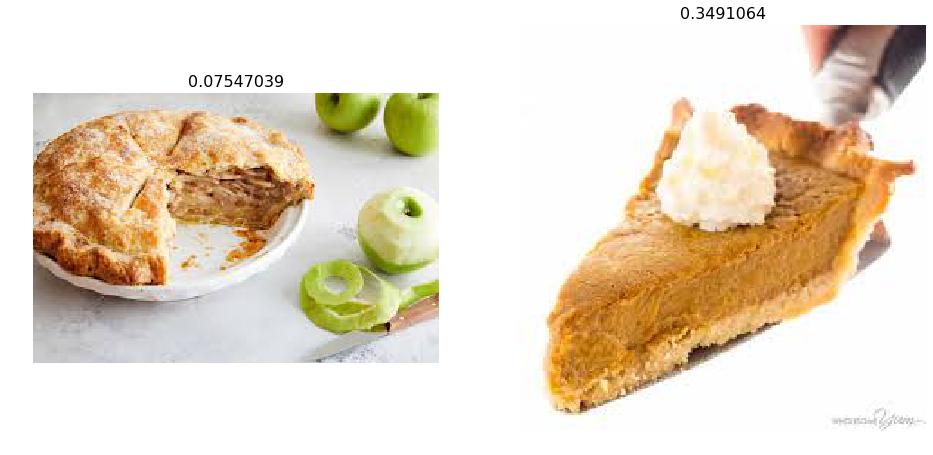

In [21]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect pies")

Most uncertain predictions


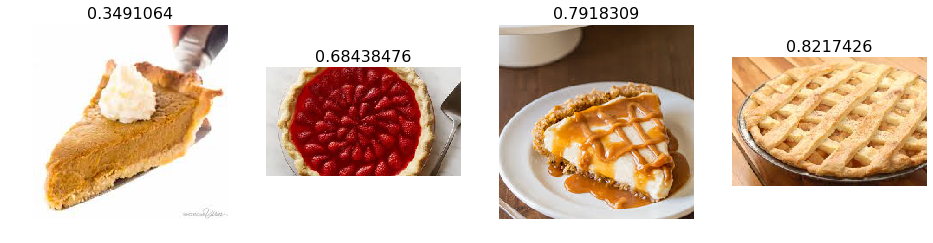

In [22]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")